In [25]:
import pandas as pd
import numpy as np
import gc

# Lab event 시간구간으로 평균값

In [26]:
''' (2021.10.28) 수정 '''

lab = pd.read_csv('./sungbin/10_05_LAB_DIAG_INTIME.csv'); print(lab.shape)
lab = lab[lab['VALUENUM'].notnull()] # VALUE가 문자인것 다제거.
print(lab.shape)

def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)
min_max = lab[['ITEMID', 'VALUENUM']].groupby(['ITEMID']).agg([min,max,q1,q3])
min_max = min_max.reset_index(drop=False)
min_max = min_max.set_axis(['ITEMID', 'MIN', 'MAX','25th','75th'], axis=1)
min_max['IQR'] = min_max['75th'] - min_max['25th']
min_max['minimum'] = min_max['25th'] - min_max['IQR']
min_max['maximum'] = min_max['75th'] + min_max['IQR']
min_max

new = pd.merge(lab, min_max, on='ITEMID', how='left') # 머지하기
new = new.loc[(new.VALUENUM >= new['minimum']) & (new.VALUENUM <= new['maximum'])] # 이상치 제거
new = new[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','CAL_LAB_TIME','ITEMID','VALUENUM']] # 정규화 하지 않기 
new 

(1654605, 13)
(1486879, 13)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CAL_LAB_TIME,ITEMID,VALUENUM
0,15787,122380.0,260844.0,8.0,50818,33.00
1,15787,122380.0,260844.0,8.0,50820,7.42
2,15787,122380.0,260844.0,8.0,50821,183.00
3,15787,122380.0,260844.0,12.0,50912,1.30
4,15787,122380.0,260844.0,12.0,51006,18.00
...,...,...,...,...,...,...
1486874,79069,115164.0,226424.0,19.0,51274,11.80
1486875,79069,115164.0,226424.0,19.0,51275,27.90
1486876,79069,115164.0,226424.0,19.0,51277,17.10
1486877,79069,115164.0,226424.0,19.0,51279,3.27


In [27]:
MEAN = new.groupby(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','ITEMID', 'CAL_LAB_TIME'])['VALUENUM'].mean()
MEAN = MEAN.reset_index(name='MEAN_VALUENUM')
MEAN

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CAL_LAB_TIME,MEAN_VALUENUM
0,3,145834.0,211552.0,50801,2.0,403.00
1,3,145834.0,211552.0,50802,0.0,-4.00
2,3,145834.0,211552.0,50802,13.0,-5.00
3,3,145834.0,211552.0,50802,15.0,-6.00
4,3,145834.0,211552.0,50802,20.0,-5.00
...,...,...,...,...,...,...
1318553,99995,137810.0,229633.0,51275,17.0,34.70
1318554,99995,137810.0,229633.0,51279,1.0,2.86
1318555,99995,137810.0,229633.0,51279,12.0,3.13
1318556,99995,137810.0,229633.0,51301,1.0,8.20


# Labevents 피처수 줄이기(280->60)

In [28]:
# MEAN[].unique().shape
# MEAN.to_csv("./1101_mean.csv",index=False)

In [37]:
# MEAN = pd.read_csv("./1101_mean.csv")
MEAN['ITEMID'].value_counts()[:12]
MEAN

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CAL_LAB_TIME,MEAN_VALUENUM
0,3,145834.0,211552.0,50801,2.0,403.00
1,3,145834.0,211552.0,50802,0.0,-4.00
2,3,145834.0,211552.0,50802,13.0,-5.00
3,3,145834.0,211552.0,50802,15.0,-6.00
4,3,145834.0,211552.0,50802,20.0,-5.00
...,...,...,...,...,...,...
1318553,99995,137810.0,229633.0,51275,17.0,34.70
1318554,99995,137810.0,229633.0,51279,1.0,2.86
1318555,99995,137810.0,229633.0,51279,12.0,3.13
1318556,99995,137810.0,229633.0,51301,1.0,8.20


In [30]:
table = pd.pivot_table(MEAN, values='MEAN_VALUENUM', index=['ICUSTAY_ID', 'CAL_LAB_TIME'],
                    columns=['ITEMID'])
table

ITEMID                   50801  50802  50803  50804  50805  50806  50808  \
ICUSTAY_ID CAL_LAB_TIME                                                    
200003.0   2.0             NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           5.0             NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           6.0             NaN   -5.0    NaN   20.0    NaN    NaN   1.05   
           7.0             NaN   -2.0    NaN   23.0    NaN    NaN    NaN   
           14.0            NaN    0.0    NaN   24.0    NaN    NaN    NaN   
...                        ...    ...    ...    ...    ...    ...    ...   
299999.0   11.0            NaN    0.0    NaN   26.0    NaN  107.0   1.28   
           13.0            NaN    1.0    NaN   28.0    NaN    NaN   1.04   
           16.0            NaN    0.0    NaN   25.0    NaN    NaN   1.16   
           21.0            NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           22.0            NaN    NaN    NaN    NaN    NaN    NaN    NaN   

ITEMID                   50809  50810  50811  ...  51493  51494  51497  51498  \
ICUSTAY_ID CAL_LAB_TIME                       ...                               
200003.0   2.0             NaN    NaN    NaN  ...    NaN    NaN    NaN  1.022   
           5.0             NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN   
           6.0             NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN   
           7.0             NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN   
           14.0            NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN   
...                        ...    ...    ...  ...    ...    ...    ...    ...   
299999.0   11.0          109.0    NaN    NaN  ...    NaN    NaN    NaN    NaN   
           13.0          137.0   36.0   11.9  ...    NaN    NaN    NaN    NaN   
           16.0          159.0    NaN    NaN  ...    NaN    NaN    NaN    NaN   
           21.0            NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN   
           22.0          103.0    NaN    NaN  ...    NaN    NaN    NaN    NaN   

ITEMID                   51501  51507  51514  51516  51517  51519  
ICUSTAY_ID CAL_LAB_TIME                                            
200003.0   2.0             NaN    NaN    NaN    NaN    NaN    NaN  
           5.0             NaN    NaN    NaN    NaN    NaN    NaN  
           6.0             NaN    NaN    NaN    NaN    NaN    NaN  
           7.0             NaN    NaN    NaN    NaN    NaN    NaN  
           14.0            NaN    NaN    NaN    NaN    NaN    NaN  
...                        ...    ...    ...    ...    ...    ...  
299999.0   11.0            NaN    NaN    NaN    NaN    NaN    NaN  
           13.0            NaN    NaN    NaN    NaN    NaN    NaN  
           16.0            NaN    NaN    NaN    NaN    NaN    NaN  
           21.0            NaN    NaN    NaN    NaN    NaN    NaN  
           22.0            NaN    NaN    NaN    NaN    NaN    NaN  

[110334 rows x 353 columns]

In [38]:
# ls = table.notnull().sum().sort_values(ascending=False).index[:12]
# 저번 9월 2일?? 쯤 피처 
ls = [50868,50882,50902,50912,50931,50971,50983,51006,51221,51222,51265]
for_mer = pd.DataFrame(ls, columns=['ITEMID'])
lab_new = pd.merge(MEAN, for_mer, on='ITEMID', how='inner')
print(len(lab_new.ITEMID.unique()))
lab_new

11


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CAL_LAB_TIME,MEAN_VALUENUM
0,3,145834.0,211552.0,50868,7.0,19.0
1,3,145834.0,211552.0,50868,17.0,15.0
2,13,143045.0,263738.0,50868,1.0,14.0
3,13,143045.0,263738.0,50868,12.0,10.0
4,20,157681.0,264490.0,50868,11.0,12.0
...,...,...,...,...,...,...
314841,99991,151118.0,226241.0,50912,4.0,1.2
314842,99991,151118.0,226241.0,50912,10.0,1.0
314843,99991,151118.0,226241.0,50912,21.0,0.9
314844,99995,137810.0,229633.0,50912,1.0,0.4


In [39]:
# lab_new.to_csv('./sungbin/10_28_LAB_12ITEMS.csv',index=False)
lab_new.to_csv('./sungbin/11_01_LAB_11ITEMS.csv',index=False)

In [40]:
# lab = pd.read_csv('./sungbin/10_28_LAB_50ITEMS.csv')
# lab = pd.read_csv('./sungbin/10_28_LAB_12ITEMS.csv')
lab = pd.read_csv('./sungbin/11_01_LAB_11ITEMS.csv')
lab.head()


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CAL_LAB_TIME,MEAN_VALUENUM
0,3,145834.0,211552.0,50868,7.0,19.0
1,3,145834.0,211552.0,50868,17.0,15.0
2,13,143045.0,263738.0,50868,1.0,14.0
3,13,143045.0,263738.0,50868,12.0,10.0
4,20,157681.0,264490.0,50868,11.0,12.0


# Chartevent도 시간 구간으로 평균값

In [17]:
chart = pd.read_csv('./sungbin/10_06_CHART_DIAG_INTIME.csv')
chart.head()

def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)
min_max = chart[['ITEMID', 'VALUENUM']].groupby(['ITEMID']).agg([min,max,q1,q3])
min_max = min_max.reset_index(drop=False)
min_max = min_max.set_axis(['ITEMID', 'MIN', 'MAX','25th','75th'], axis=1)
min_max['IQR'] = min_max['75th'] - min_max['25th']
min_max['minimum'] = min_max['25th'] - min_max['IQR']
min_max['maximum'] = min_max['75th'] + min_max['IQR']
min_max

new = pd.merge(chart, min_max, on='ITEMID', how='left') # 머지하기
new = new.loc[(new.VALUENUM >= new['minimum']) & (new.VALUENUM <= new['maximum'])] # 이상치 제거
new['VALUENUM_NORM'] = (new.VALUENUM - new.MIN)/ (new.MAX - new.MIN) # 정규화하기
new = new[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','CAL_CHART_TIME','ITEMID','VALUENUM']]
new

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CAL_CHART_TIME,ITEMID,VALUENUM
0,31123,154148,209103.0,10.0,220179,104.0
1,31123,154148,209103.0,10.0,220180,64.0
2,31123,154148,209103.0,11.0,220045,73.0
3,31123,154148,209103.0,11.0,220210,24.0
4,31123,154148,209103.0,11.0,220277,98.0
...,...,...,...,...,...,...
743465,79069,115164,226424.0,9.0,220045,74.0
743466,79069,115164,226424.0,9.0,220179,102.0
743467,79069,115164,226424.0,9.0,220180,67.0
743468,79069,115164,226424.0,9.0,220210,13.0


In [18]:
MEAN = new.groupby(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','ITEMID', 'CAL_CHART_TIME'])['VALUENUM'].mean()
MEAN = MEAN.reset_index(name='MEAN_VALUENUM')
MEAN

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CAL_CHART_TIME,MEAN_VALUENUM
0,533,100009,253656.0,220045,8.0,80.000000
1,533,100009,253656.0,220045,9.0,86.666667
2,533,100009,253656.0,220045,10.0,80.000000
3,533,100009,253656.0,220045,11.0,80.000000
4,533,100009,253656.0,220045,12.0,80.000000
...,...,...,...,...,...,...
505114,99995,137810,229633.0,223761,6.0,98.800000
505115,99995,137810,229633.0,223761,10.0,98.400000
505116,99995,137810,229633.0,223761,14.0,98.500000
505117,99995,137810,229633.0,223761,18.0,99.700000


In [23]:
MEAN.to_csv('./sungbin/10_28_CHART_MEAN_VALUENUM.csv', index=False)

# CHART and LAB merge!

In [41]:
# lab = pd.read_csv('./sungbin/10_28_LAB_50ITEMS.csv') # 50
# lab = pd.read_csv('./sungbin/10_28_LAB_12ITEMS.csv') # 12
lab = pd.read_csv('./sungbin/11_01_LAB_11ITEMS.csv') # 12
chart = pd.read_csv('./sungbin/10_28_CHART_MEAN_VALUENUM.csv')

In [42]:
lab.rename(columns={'CAL_LAB_TIME' : 'CAL_TIME'}, inplace = True)
chart.rename(columns={'CAL_CHART_TIME' : 'CAL_TIME'}, inplace = True)

In [43]:
print(chart.shape)
print(lab.shape)

(505119, 6)
(314846, 6)


In [44]:
new_merge = pd.merge(lab, chart, on=['SUBJECT_ID','HADM_ID','ICUSTAY_ID','CAL_TIME','ITEMID','MEAN_VALUENUM'], how='outer')
print(new_merge.shape)

(819965, 6)


In [45]:
table = pd.pivot_table(new_merge, values='MEAN_VALUENUM', index=['SUBJECT_ID','HADM_ID','ICUSTAY_ID', 'CAL_TIME'],
                    columns=['ITEMID'])
table

ITEMID                                   50868   50882   50902   50912   \
SUBJECT_ID HADM_ID  ICUSTAY_ID CAL_TIME                                   
3          145834.0 211552.0   0.0          NaN     NaN   111.0     NaN   
                               7.0         19.0     NaN   110.0     NaN   
                               17.0        15.0    17.0   111.0     NaN   
                               23.0         NaN     NaN     NaN     NaN   
13         143045.0 263738.0   1.0         14.0    23.0   106.0     0.6   
...                                         ...     ...     ...     ...   
99995      137810.0 229633.0   19.0         NaN     NaN     NaN     NaN   
                               20.0         NaN     NaN     NaN     NaN   
                               21.0         NaN     NaN     NaN     NaN   
                               22.0         NaN     NaN     NaN     NaN   
                               23.0         NaN     NaN     NaN     NaN   

ITEMID                                   50931   50971   50983   51006   \
SUBJECT_ID HADM_ID  ICUSTAY_ID CAL_TIME                                   
3          145834.0 211552.0   0.0        162.0    4.05   141.5    42.0   
                               7.0          NaN    4.40   138.0    42.0   
                               17.0       157.0    3.90   139.0     NaN   
                               23.0         NaN    4.90     NaN     NaN   
13         143045.0 263738.0   1.0        169.0    3.50   139.0    13.0   
...                                         ...     ...     ...     ...   
99995      137810.0 229633.0   19.0         NaN     NaN     NaN     NaN   
                               20.0         NaN     NaN     NaN     NaN   
                               21.0         NaN     NaN     NaN     NaN   
                               22.0         NaN     NaN     NaN     NaN   
                               23.0         NaN     NaN     NaN     NaN   

ITEMID                                   51221   51222   51265   220045  \
SUBJECT_ID HADM_ID  ICUSTAY_ID CAL_TIME                                   
3          145834.0 211552.0   0.0        25.25     8.0   221.5     NaN   
                               7.0        30.30     9.7     NaN     NaN   
                               17.0         NaN     NaN     NaN     NaN   
                               23.0       30.90    10.4   219.0     NaN   
13         143045.0 263738.0   1.0        35.60    12.3   216.0     NaN   
...                                         ...     ...     ...     ...   
99995      137810.0 229633.0   19.0         NaN     NaN     NaN    84.0   
                               20.0         NaN     NaN     NaN    80.0   
                               21.0         NaN     NaN     NaN    83.0   
                               22.0         NaN     NaN     NaN    81.0   
                               23.0         NaN     NaN     NaN    74.0   

ITEMID                                   220179  220180  220210  220277  \
SUBJECT_ID HADM_ID  ICUSTAY_ID CAL_TIME                                   
3          145834.0 211552.0   0.0          NaN     NaN     NaN     NaN   
                               7.0          NaN     NaN     NaN     NaN   
                               17.0         NaN     NaN     NaN     NaN   
                               23.0         NaN     NaN     NaN     NaN   
13         143045.0 263738.0   1.0          NaN     NaN     NaN     NaN   
...                                         ...     ...     ...     ...   
99995      137810.0 229633.0   19.0         NaN     NaN    24.0    97.0   
                               20.0         NaN     NaN    21.0    98.0   
                               21.0         NaN     NaN    25.0    99.0   
                               22.0         NaN     NaN    19.0    99.0   
                               23.0         NaN     NaN    23.0    99.0   

ITEMID                                   223761  
SUBJECT_ID HADM_ID  ICUSTAY_ID CAL_TIME       

In [46]:
# table.to_csv('./sungbin/10_29_CHART_LAB_MERGE.csv', index=True)
table.to_csv('./sungbin/11_01_CHART_LAB_MERGE.csv', index=True)

# CHART_LAB + PATIENTS merge!

In [47]:
# chart_lab = pd.read_csv('./sungbin/10_28_CHART_LAB_MERGE.csv')
# chart_lab = pd.read_csv('./sungbin/10_29_CHART_LAB_MERGE.csv') # lab itemid12
chart_lab = pd.read_csv('./sungbin/11_01_CHART_LAB_MERGE.csv') # lab itemid11

In [48]:
chart_lab

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CAL_TIME,50868,50882,50902,50912,50931,50971,...,51006,51221,51222,51265,220045,220179,220180,220210,220277,223761
0,3,145834.0,211552.0,0.0,NaN,NaN,111.0,NaN,162.0,4.05,...,42.0,25.25,8.0,221.5,NaN,NaN,NaN,NaN,NaN,NaN
1,3,145834.0,211552.0,7.0,19.0,NaN,110.0,NaN,NaN,4.40,...,42.0,30.30,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,145834.0,211552.0,17.0,15.0,17.0,111.0,NaN,157.0,3.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,145834.0,211552.0,23.0,NaN,NaN,NaN,NaN,NaN,4.90,...,NaN,30.90,10.4,219.0,NaN,NaN,NaN,NaN,NaN,NaN
4,13,143045.0,263738.0,1.0,14.0,23.0,106.0,0.6,169.0,3.50,...,13.0,35.60,12.3,216.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161220,99995,137810.0,229633.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,84.0,NaN,NaN,24.0,97.0,NaN
161221,99995,137810.0,229633.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,80.0,NaN,NaN,21.0,98.0,NaN
161222,99995,137810.0,229633.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,83.0,NaN,NaN,25.0,99.0,NaN
161223,99995,137810.0,229633.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.0,NaN,NaN,19.0,99.0,98.8


In [49]:
pat = pd.read_csv('./sungbin/10_05_PATIENTS_DIAG_INTIME.csv')
pat = pat[['ICUSTAY_ID','GENDER','CAL_AGE']]
pat
print(chart_lab.shape)
print(pat.shape)

merge = pd.merge(chart_lab, pat, on='ICUSTAY_ID', how='inner')
print(merge.shape)

(161225, 21)
(16222, 3)
(161225, 23)


In [50]:
merge
merge.to_csv('./sungbin/11_01_CHART_LAB_PATIENTS.csv',index=False)

In [51]:
merge

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CAL_TIME,50868,50882,50902,50912,50931,50971,...,51222,51265,220045,220179,220180,220210,220277,223761,GENDER,CAL_AGE
0,3,145834.0,211552.0,0.0,NaN,NaN,111.0,NaN,162.0,4.05,...,8.0,221.5,NaN,NaN,NaN,NaN,NaN,NaN,M,76.0
1,3,145834.0,211552.0,7.0,19.0,NaN,110.0,NaN,NaN,4.40,...,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,76.0
2,3,145834.0,211552.0,17.0,15.0,17.0,111.0,NaN,157.0,3.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,76.0
3,3,145834.0,211552.0,23.0,NaN,NaN,NaN,NaN,NaN,4.90,...,10.4,219.0,NaN,NaN,NaN,NaN,NaN,NaN,M,76.0
4,13,143045.0,263738.0,1.0,14.0,23.0,106.0,0.6,169.0,3.50,...,12.3,216.0,NaN,NaN,NaN,NaN,NaN,NaN,F,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161220,99995,137810.0,229633.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,84.0,NaN,NaN,24.0,97.0,NaN,F,88.0
161221,99995,137810.0,229633.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,80.0,NaN,NaN,21.0,98.0,NaN,F,88.0
161222,99995,137810.0,229633.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.0,NaN,NaN,25.0,99.0,NaN,F,88.0
161223,99995,137810.0,229633.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,81.0,NaN,NaN,19.0,99.0,98.8,F,88.0


# carry forward 방식으로 대체하기

In [52]:
# merge = pd.read_csv('./sungbin/10_28_CHART_LAB_PATIENTS.csv') # 50
merge = pd.read_csv('./sungbin/10_29_CHART_LAB_PATIENTS.csv') # 12
merge = merge.sort_values(['ICUSTAY_ID', 'CAL_TIME']).reset_index(drop=True)
merge

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CAL_TIME,50802,50804,50808,50809,50817,50818,...,51222,51265,220045,220179,220180,220210,220277,223761,GENDER,CAL_AGE
0,27513,163557.0,200003.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
1,27513,163557.0,200003.0,6.0,-5.0,20.0,1.05,NaN,96.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
2,27513,163557.0,200003.0,7.0,-2.0,23.0,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
3,27513,163557.0,200003.0,14.0,0.0,24.0,NaN,NaN,NaN,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
4,27513,163557.0,200003.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10.8,119.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197710,7630,129161.0,299999.0,11.0,0.0,26.0,1.28,109.0,NaN,41.0,...,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
197711,7630,129161.0,299999.0,13.0,1.0,28.0,1.04,137.0,98.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
197712,7630,129161.0,299999.0,16.0,0.0,25.0,1.16,159.0,98.0,41.0,...,11.9,258.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
197713,7630,129161.0,299999.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11.5,290.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0


In [53]:
merge.ICUSTAY_ID.unique()

array([200003., 200007., 200009., ..., 299981., 299992., 299999.])

In [54]:
default = pd.DataFrame()
for i in merge.ICUSTAY_ID.unique():
    default = default.append(merge[merge['ICUSTAY_ID'] == i].fillna(method="ffill"))

# merge.fillna(method="ffill")

In [55]:
default.to_csv('./sungbin/11_01_FFILL_CHART_LAB_PATIENTS.csv',index=False)

# 포워드 필로도 부족하다면 평균값으로 대체 하여 predict

In [56]:
default

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CAL_TIME,50802,50804,50808,50809,50817,50818,...,51222,51265,220045,220179,220180,220210,220277,223761,GENDER,CAL_AGE
0,27513,163557.0,200003.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
1,27513,163557.0,200003.0,6.0,-5.0,20.0,1.05,NaN,96.0,34.0,...,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
2,27513,163557.0,200003.0,7.0,-2.0,23.0,1.05,NaN,96.0,37.0,...,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
3,27513,163557.0,200003.0,14.0,0.0,24.0,1.05,NaN,96.0,33.0,...,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
4,27513,163557.0,200003.0,21.0,0.0,24.0,1.05,NaN,96.0,33.0,...,10.8,119.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197710,7630,129161.0,299999.0,11.0,0.0,26.0,1.28,109.0,NaN,41.0,...,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
197711,7630,129161.0,299999.0,13.0,1.0,28.0,1.04,137.0,98.0,46.0,...,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
197712,7630,129161.0,299999.0,16.0,0.0,25.0,1.16,159.0,98.0,41.0,...,11.9,258.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
197713,7630,129161.0,299999.0,21.0,0.0,25.0,1.16,159.0,98.0,41.0,...,11.5,290.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0


In [57]:
# default = pd.read_csv('./sungbin/10_28_FFILL_CHART_LAB_PATIENTS.csv')
# default = pd.read_csv('./sungbin/10_29_FFILL_CHART_LAB_PATIENTS.csv')
default = pd.read_csv('./sungbin/11_01_FFILL_CHART_LAB_PATIENTS.csv')
item_cols = default.columns.drop(['SUBJECT_ID','HADM_ID', 'ICUSTAY_ID', 'CAL_TIME','GENDER', 'CAL_AGE'])
# print(default[item_cols].isnull().sum() / default.shape[0] ) # 결손치 큰 아이템아이디 제거위해 확인.
trash_item = item_cols[(default[item_cols].isnull().sum() / default.shape[0]) > 0.7] # 결손치가 0.7보다 큰 아이템아이디는 제거하
# default
ls = list(trash_item)
# ls.extend(['50809','50811']) # Glucose중복
ls

[]

In [58]:
cleanse_item = default.drop(ls,axis=1)
# cleanse_item.columns.shape
cleanse_item

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CAL_TIME,50802,50804,50808,50809,50817,50818,...,51222,51265,220045,220179,220180,220210,220277,223761,GENDER,CAL_AGE
0,27513,163557.0,200003.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
1,27513,163557.0,200003.0,6.0,-5.0,20.0,1.05,NaN,96.0,34.0,...,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
2,27513,163557.0,200003.0,7.0,-2.0,23.0,1.05,NaN,96.0,37.0,...,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
3,27513,163557.0,200003.0,14.0,0.0,24.0,1.05,NaN,96.0,33.0,...,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
4,27513,163557.0,200003.0,21.0,0.0,24.0,1.05,NaN,96.0,33.0,...,10.8,119.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197710,7630,129161.0,299999.0,11.0,0.0,26.0,1.28,109.0,NaN,41.0,...,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
197711,7630,129161.0,299999.0,13.0,1.0,28.0,1.04,137.0,98.0,46.0,...,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
197712,7630,129161.0,299999.0,16.0,0.0,25.0,1.16,159.0,98.0,41.0,...,11.9,258.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0
197713,7630,129161.0,299999.0,21.0,0.0,25.0,1.16,159.0,98.0,41.0,...,11.5,290.0,NaN,NaN,NaN,NaN,NaN,NaN,M,48.0


In [59]:
mean_cleanse_df = cleanse_item.fillna(cleanse_item.mean()) # 평균값으로 다 대체하여 메꿈.

In [60]:
mean_cleanse_df.to_csv('./sungbin/11_01_TotalMean_cleanse_FFILL_CHART_LAB_PATIENTS.csv',index=False)

# PRBC 붙이기

In [61]:
# chart_lab_pat = pd.read_csv('./sungbin/10_28_TotalMean_cleanse_FFILL_CHART_LAB_PATIENTS.csv')
# chart_lab_pat = pd.read_csv('./sungbin/10_29_TotalMean_cleanse_FFILL_CHART_LAB_PATIENTS.csv')
chart_lab_pat = pd.read_csv('./sungbin/11_01_TotalMean_cleanse_FFILL_CHART_LAB_PATIENTS.csv')
# from tqdm import tqdm
chart_lab_pat["ICUSTAY_ID"] = chart_lab_pat.ICUSTAY_ID.astype('int')
chart_lab_pat["CAL_TIME"] = chart_lab_pat.CAL_TIME.astype('int')


def func(row):
    time = row.CAL_TIME
    if time >= 0 and time < 4:
        return f'{row.ICUSTAY_ID}_0'
    elif time >= 4 and time < 8:
        return f'{row.ICUSTAY_ID}_4'
    elif time >= 8 and time < 12:
        return f'{row.ICUSTAY_ID}_8'
    elif time >= 12 and time < 16:
        return f'{row.ICUSTAY_ID}_12'
    elif time >= 16 and time < 20:
        return f'{row.ICUSTAY_ID}_16'
    else:
        return f'{row.ICUSTAY_ID}_20'
    
chart_lab_pat['new_time'] = chart_lab_pat.apply(lambda row: func(row), axis=1)
new = chart_lab_pat.iloc[:,4:].groupby(['new_time']).mean()
new

non_num = chart_lab_pat[['GENDER','new_time']]
dup_non_num = non_num.drop_duplicates()
dup_non_num

chart_lab_pat_merge = pd.merge(new, dup_non_num, on='new_time', how='inner')
chart_lab_pat_merge

''' AGE >89 = 90 & normalization'''
from sklearn.preprocessing import MinMaxScaler
# minmax = MinMaxScaler()
chart_lab_pat_merge[chart_lab_pat_merge['CAL_AGE'] > 89]['CAL_AGE'] = 90
# chart_lab_pat_merge['CAL_AGE'] = minmax.fit_transform(chart_lab_pat_merge['CAL_AGE'].values.reshape(-1,1))
chart_lab_pat_merge

chart_lab_pat_merge['GENDER'] = chart_lab_pat_merge.apply(lambda row : 0 if row.GENDER == 'M' else 1, axis=1)
chart_lab_pat_merge

,new_time,50802,50804,50808,50809,50817,50818,50820,50821,50822,...,51222,51265,220045,220179,220180,220210,220277,223761,CAL_AGE,GENDER
0,200003_12,0.000000,24.000000,1.050000,129.918656,96.000000,33.000000,7.460000,108.000000,4.177778,...,10.533138,109.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0
1,200003_20,0.500000,26.000000,1.050000,129.918656,97.000000,38.500000,7.427500,113.250000,4.177778,...,10.800000,119.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0
2,200003_4,-2.737841,22.445764,1.080214,129.918656,93.719492,37.089683,7.370889,107.775665,4.177778,...,10.533138,109.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0
3,200007_16,-1.213523,24.337291,1.140642,129.918656,89.158476,40.269048,7.372668,141.326994,4.177778,...,13.300000,247.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,43.0,0
4,200009_0,-1.213523,29.000000,1.100000,93.500000,89.158476,37.500000,7.460000,141.326994,4.450000,...,10.533138,177.977628,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,47.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74273,299999_12,1.000000,28.000000,1.040000,137.000000,98.000000,46.000000,7.380000,129.000000,4.600000,...,10.533138,184.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0
74274,299999_16,0.000000,25.000000,1.160000,159.000000,98.000000,41.000000,7.380000,123.000000,4.300000,...,11.900000,258.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0
74275,299999_20,0.000000,25.000000,1.160000,131.000000,96.500000,41.000000,7.380000,123.000000,4.400000,...,11.500000,290.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0
74276,299999_4,0.500000,26.000000,1.230000,107.500000,89.158476,41.500000,7.390000,255.163497,4.950000,...,10.533138,177.977628,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0


In [62]:

''' pRBC 4 hours time binding'''

prbc = pd.read_csv('sungbin/10_05_PRBC_INTIME.csv')
prbc["ICUSTAY_ID"] = prbc.ICUSTAY_ID.astype('int')
prbc["CAL_PRBC_TIME"] = prbc.CAL_PRBC_TIME.astype('int')
def func_prbc_next_time(row):
    time = row.CAL_PRBC_TIME
    if time >= 0 and time < 4:
        return f'{row.ICUSTAY_ID}_non'
    elif time >= 4 and time < 8:
        return f'{row.ICUSTAY_ID}_0'
    elif time >= 8 and time < 12:
        return f'{row.ICUSTAY_ID}_4'
    elif time >= 12 and time < 16:
        return f'{row.ICUSTAY_ID}_8'
    elif time >= 16 and time < 20:
        return f'{row.ICUSTAY_ID}_12'
    elif time >= 20 and time < 24:
        return f'{row.ICUSTAY_ID}_16'
    else:
        return f'{row.ICUSTAY_ID}_20'
    
def func_prbc_same_time(row):
    time = row.CAL_PRBC_TIME
    if time >= 0 and time < 4:
        return f'{row.ICUSTAY_ID}_0'
    elif time >= 4 and time < 8:
        return f'{row.ICUSTAY_ID}_4'
    elif time >= 8 and time < 12:
        return f'{row.ICUSTAY_ID}_8'
    elif time >= 12 and time < 16:
        return f'{row.ICUSTAY_ID}_12'
    elif time >= 16 and time < 20:
        return f'{row.ICUSTAY_ID}_16'
    elif time >= 20 and time < 24:
        return f'{row.ICUSTAY_ID}_20'
    else:
        return f'{row.ICUSTAY_ID}_non'
    
prbc['new_time'] = prbc.apply(lambda row: func_prbc_next_time(row), axis=1)
prbc

for_merge_prbc = prbc[['new_time','label']]
for_merge_prbc = for_merge_prbc.drop_duplicates()
for_merge_prbc

chart_lab_pat_prbc = pd.merge(chart_lab_pat_merge,for_merge_prbc,on='new_time',how='left')
chart_lab_pat_prbc['label'] = chart_lab_pat_prbc['label'].fillna(0)
print(chart_lab_pat_merge.shape)
print(for_merge_prbc.shape)
print(chart_lab_pat_prbc.shape)

chart_lab_pat_prbc


(74278, 21)
(7887, 2)
(74278, 22)


,new_time,50802,50804,50808,50809,50817,50818,50820,50821,50822,...,51265,220045,220179,220180,220210,220277,223761,CAL_AGE,GENDER,label
0,200003_12,0.000000,24.000000,1.050000,129.918656,96.000000,33.000000,7.460000,108.000000,4.177778,...,109.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
1,200003_20,0.500000,26.000000,1.050000,129.918656,97.000000,38.500000,7.427500,113.250000,4.177778,...,119.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
2,200003_4,-2.737841,22.445764,1.080214,129.918656,93.719492,37.089683,7.370889,107.775665,4.177778,...,109.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
3,200007_16,-1.213523,24.337291,1.140642,129.918656,89.158476,40.269048,7.372668,141.326994,4.177778,...,247.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,43.0,0,0.0
4,200009_0,-1.213523,29.000000,1.100000,93.500000,89.158476,37.500000,7.460000,141.326994,4.450000,...,177.977628,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,47.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74273,299999_12,1.000000,28.000000,1.040000,137.000000,98.000000,46.000000,7.380000,129.000000,4.600000,...,184.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
74274,299999_16,0.000000,25.000000,1.160000,159.000000,98.000000,41.000000,7.380000,123.000000,4.300000,...,258.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
74275,299999_20,0.000000,25.000000,1.160000,131.000000,96.500000,41.000000,7.380000,123.000000,4.400000,...,290.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
74276,299999_4,0.500000,26.000000,1.230000,107.500000,89.158476,41.500000,7.390000,255.163497,4.950000,...,177.977628,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0


In [63]:
chart_lab_pat_prbc['label'].value_counts()

0.0    68460
1.0     5818
Name: label, dtype: int64

In [64]:
chart_lab_pat_prbc.to_csv('./sungbin/11_01_PRBC_CHART_LAB_PAT_NEXTTIME.csv', index=False)

# 모델링

In [117]:
import pandas as pd
# final_input = pd.read_csv('./sungbin/10_28_PRBC_CHART_LAB_PAT_NEXTTIME.csv') # 50
final_input = pd.read_csv('./sungbin/10_29_PRBC_CHART_LAB_PAT_NEXTTIME.csv') # 12
# final_input = pd.read_csv('./sungbin/11_01_PRBC_CHART_LAB_PAT_NEXTTIME.csv') # 11

In [118]:
final_input

,new_time,50802,50804,50808,50809,50817,50818,50820,50821,50822,...,51265,220045,220179,220180,220210,220277,223761,CAL_AGE,GENDER,label
0,200003_12,0.000000,24.000000,1.050000,129.918656,96.000000,33.000000,7.460000,108.000000,4.177778,...,109.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
1,200003_20,0.500000,26.000000,1.050000,129.918656,97.000000,38.500000,7.427500,113.250000,4.177778,...,119.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
2,200003_4,-2.737841,22.445764,1.080214,129.918656,93.719492,37.089683,7.370889,107.775665,4.177778,...,109.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
3,200007_16,-1.213523,24.337291,1.140642,129.918656,89.158476,40.269048,7.372668,141.326994,4.177778,...,247.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,43.0,0,0.0
4,200009_0,-1.213523,29.000000,1.100000,93.500000,89.158476,37.500000,7.460000,141.326994,4.450000,...,177.977628,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,47.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74273,299999_12,1.000000,28.000000,1.040000,137.000000,98.000000,46.000000,7.380000,129.000000,4.600000,...,184.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
74274,299999_16,0.000000,25.000000,1.160000,159.000000,98.000000,41.000000,7.380000,123.000000,4.300000,...,258.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
74275,299999_20,0.000000,25.000000,1.160000,131.000000,96.500000,41.000000,7.380000,123.000000,4.400000,...,290.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
74276,299999_4,0.500000,26.000000,1.230000,107.500000,89.158476,41.500000,7.390000,255.163497,4.950000,...,177.977628,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0


In [96]:
# 220045 : HR, 220179 : Non Invasive SBP, 220180: Non Invasive DBP 220210 : RR, 220277 : SpO2, 223761 : Temp

In [97]:
# merged

In [119]:
dlab=pd.read_csv('./MIMIC3/D_LABITEMS.csv')

fcols = final_input.columns.drop(['new_time','CAL_AGE','GENDER','label'])
# fcols = [int(i) for i in fcols]
fcols = pd.DataFrame(fcols, columns=['ITEMID'])
fcols
merged = pd.merge(dlab[['ITEMID','LABEL']].astype(str), fcols, on='ITEMID', how='inner')
# dlab[['ITEMID','LABEL']].astype(str)


item_list = merged.ITEMID
col_list = merged.LABEL
dictionary = dict(zip(item_list, col_list))
dictionary

final_input.rename(columns = dictionary, inplace = True)

chart_dict = {'220045' : 'HR', '220179' :' Non Invasive SBP', '220180':' Non Invasive DBP', '220210' : 'RR', '220277' : 'SpO2', '223761' : 'Temp'}

final_input.rename(columns = chart_dict, inplace = True)

In [120]:
# final_input = final_input.drop(columns=['GENDER']) # GENDER 빼고 해보기
final_input = final_input.rename(columns={'new_time':'Patien_ID'})
final_input

,Patien_ID,Base Excess,Calculated Total CO2,Free Calcium,Glucose,Oxygen Saturation,pCO2,pH,pO2,"Potassium, Whole Blood",...,Platelet Count,HR,Non Invasive SBP,Non Invasive DBP,RR,SpO2,Temp,CAL_AGE,GENDER,label
0,200003_12,0.000000,24.000000,1.050000,129.918656,96.000000,33.000000,7.460000,108.000000,4.177778,...,109.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
1,200003_20,0.500000,26.000000,1.050000,129.918656,97.000000,38.500000,7.427500,113.250000,4.177778,...,119.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
2,200003_4,-2.737841,22.445764,1.080214,129.918656,93.719492,37.089683,7.370889,107.775665,4.177778,...,109.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
3,200007_16,-1.213523,24.337291,1.140642,129.918656,89.158476,40.269048,7.372668,141.326994,4.177778,...,247.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,43.0,0,0.0
4,200009_0,-1.213523,29.000000,1.100000,93.500000,89.158476,37.500000,7.460000,141.326994,4.450000,...,177.977628,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,47.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74273,299999_12,1.000000,28.000000,1.040000,137.000000,98.000000,46.000000,7.380000,129.000000,4.600000,...,184.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
74274,299999_16,0.000000,25.000000,1.160000,159.000000,98.000000,41.000000,7.380000,123.000000,4.300000,...,258.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
74275,299999_20,0.000000,25.000000,1.160000,131.000000,96.500000,41.000000,7.380000,123.000000,4.400000,...,290.000000,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0
74276,299999_4,0.500000,26.000000,1.230000,107.500000,89.158476,41.500000,7.390000,255.163497,4.950000,...,177.977628,84.462043,113.310034,60.134458,18.559952,97.350557,98.158418,48.0,0,0.0


### XGBoost

In [100]:
# XGBoost
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score , recall_score , confusion_matrix, f1_score
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from imblearn.over_sampling import SMOTE

In [101]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


    
def roc_curve_plot_all(y_test, pred_proba_c1, model_name):
    # 임계값에 따른 FPR, TPR값을 반환받음.
    fprs , tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # Roc 곡선 그림
    plt.plot(fprs, tprs, label=f'{model_name}')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--')
    
    # FPR X 축의 Scale 을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()

def feature_importance(estimator):

    # feature importance
    ftr_importances_values = estimator.feature_importances_
    # print(ftr_importance_values)
    # Series로 변환
    ftr_importances = pd.Series(ftr_importances_values, index=final_input.drop(columns=['label','new_time']).columns)

    # 중요도 순으로 정렬
    ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]
    # print(ftr_top20)

    plt.figure(figsize=(8,6))
    plt.title('Feature importances TOP 15')
    sns.barplot(x=ftr_top15, y=ftr_top15.index)
    plt.show()


def fit_predict_models(models, X_train, X_test, y_train, y_test, models_name):
    for idx, model in enumerate(models):
        model.fit(X_train, y_train)
        pred_proba = model.predict_proba(X_test)[:, 1]
        pred = model.predict(X_test)
        
        roc_curve_plot_all(y_test, pred_proba, models_name[idx])
        print('기본적인 다른 평가:')
        get_clf_eval(y_test, pred, pred_proba)

In [102]:
features = final_input.drop(columns=['label','new_time']).values
label = final_input['label']


# smote = SMOTE(random_state=20)
# features, label = smote.fit_resample(features, label)

X_train, X_test, y_train, y_test = train_test_split(features,label, test_size=0.2, stratify=label)


smote = SMOTE(random_state=20)
X_train, y_train = smote.fit_resample(X_train, y_train)


XGBoost = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3)
LightGBM = LGBMClassifier(n_estimators=1000, num_leaves=64, boost_from_average=False)
rf_clf = RandomForestClassifier()

In [103]:
y_train.value_counts() # 비율

0.0    54768
1.0    54768
Name: label, dtype: int64

[19:49:42] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
기본적인 다른 평가:
오차 행렬
[[12933   759]
 [  793   371]]
정확도: 0.8955, 정밀도: 0.3283, 재현율: 0.3187,          F1: 0.3235, AUC:0.8099
기본적인 다른 평가:
오차 행렬
[[13238   454]
 [  893   271]]
정확도: 0.9093, 정밀도: 0.3738, 재현율: 0.2328,          F1: 0.2869, AUC:0.8222
기본적인 다른 평가:
오차 행렬
[[12615  1077]
 [  742   422]]
정확도: 0.8776, 정밀도: 0.2815, 재현율: 0.3625,          F1: 0.3169, AUC:0.8205


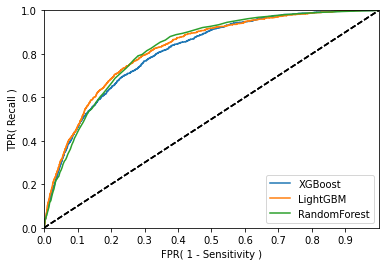

In [104]:
models = [XGBoost,LightGBM,rf_clf]
models_name = ['XGBoost','LightGBM','RandomForest']

fit_predict_models(models, X_train, X_test, y_train, y_test, models_name)


# feature importance

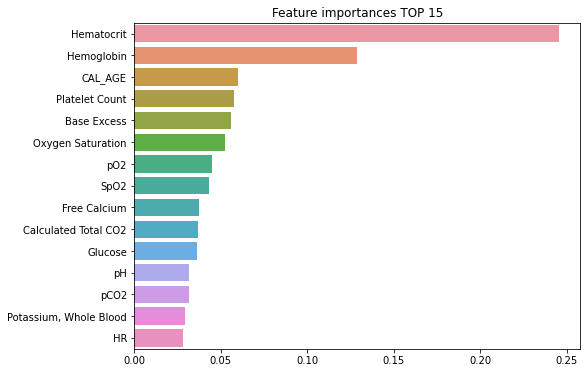

In [105]:
feature_importance(rf_clf)

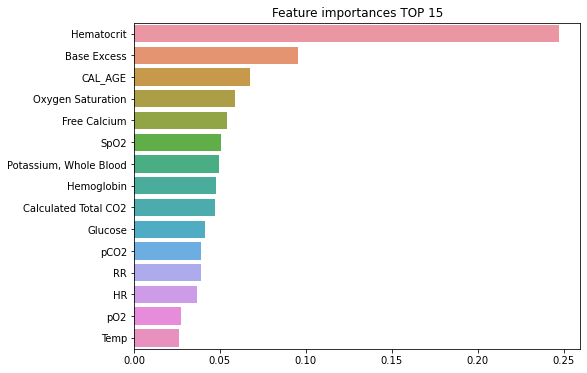

In [106]:
feature_importance(XGBoost)

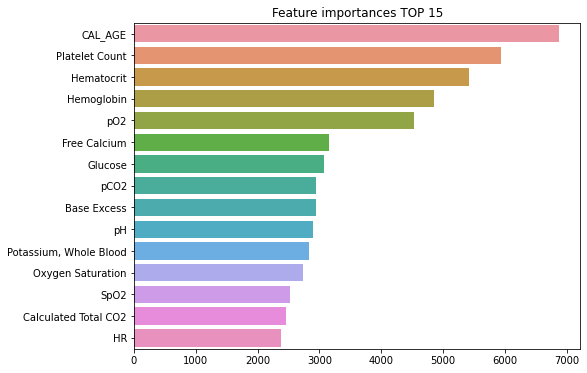

In [107]:
feature_importance(LightGBM)

# 부분 의존성 플롯 그리기


(19,)


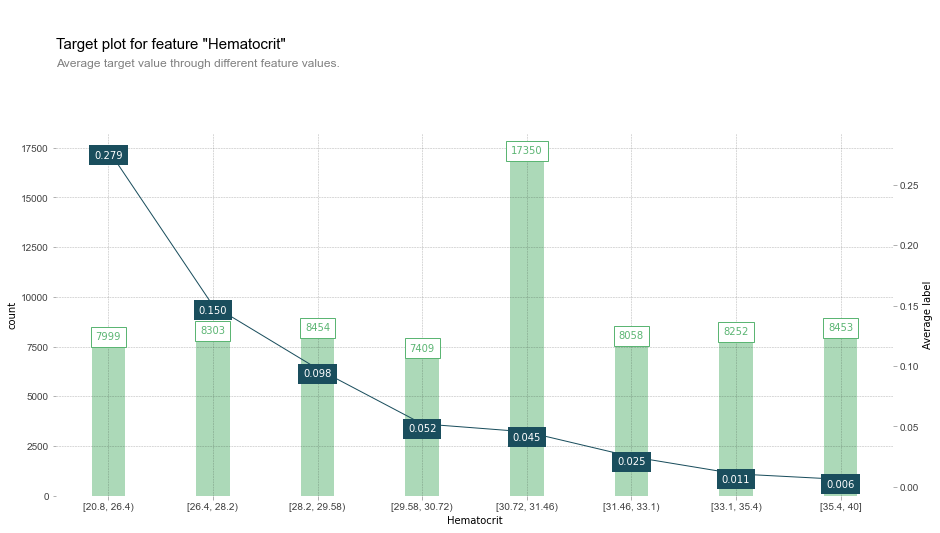

In [108]:
from pdpbox import info_plots

data = final_input.drop(columns=['new_time']).reset_index(drop=True)
features = data.columns[:-1]
label = data.columns[-1]
print(features.shape)

fig, axes, summary_df = info_plots.target_plot(
    df = data,
    feature='Hematocrit',
    feature_name='Hematocrit',
    target=label)


(19,)


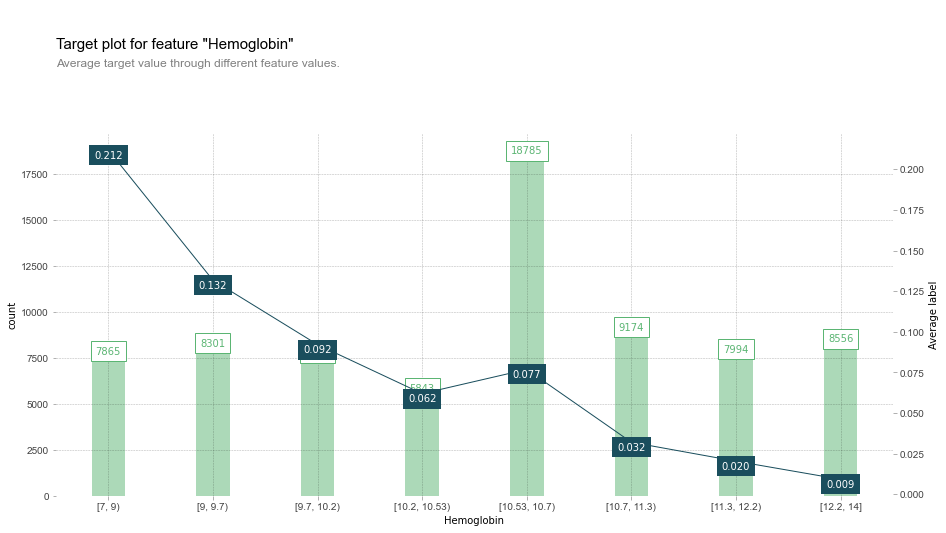

In [109]:
from pdpbox import info_plots

data = final_input.drop(columns=['new_time']).reset_index(drop=True)
features = data.columns[:-1]
label = data.columns[-1]
print(features.shape)

fig, axes, summary_df = info_plots.target_plot(
    df = data,
    feature='Hemoglobin',
    feature_name='Hemoglobin',
    target=label)


# 실제 분포 예측 결과

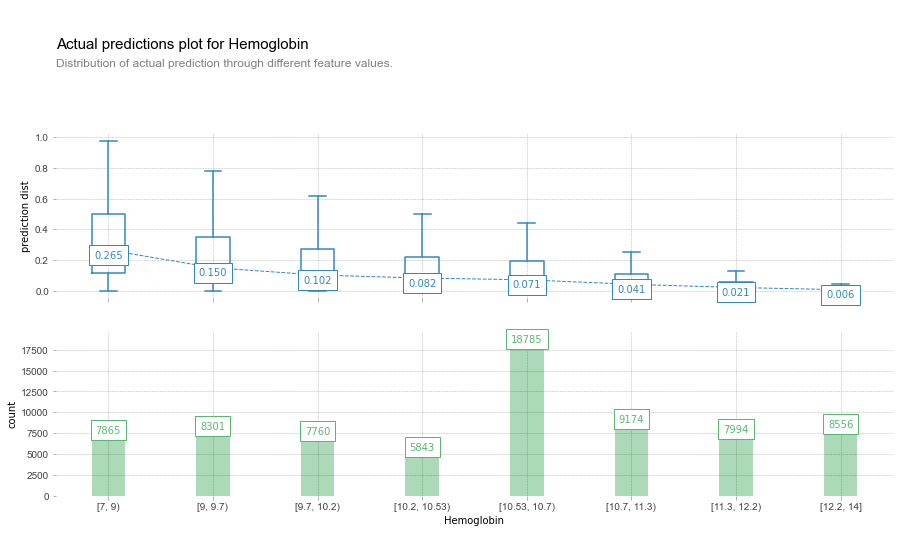

In [110]:
data = final_input.drop(columns=['new_time']).reset_index(drop=True)
features = data.columns[:-1]
label = data.columns[-1]

fig, axes ,summary_df = info_plots.actual_plot(
    model = XGBoost,
    X = data[features],
    feature='Hemoglobin',
    feature_name='Hemoglobin',
    predict_kwds={})

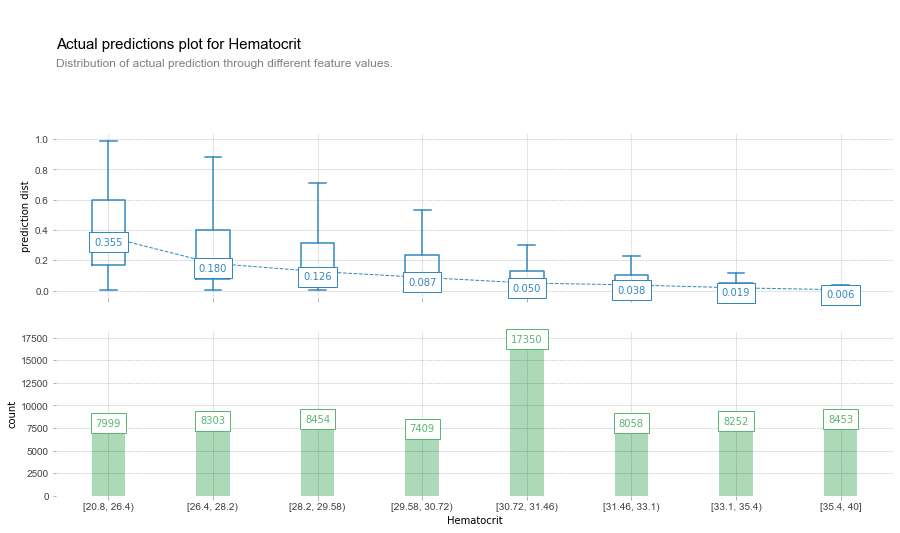

In [111]:
data = final_input.drop(columns=['new_time']).reset_index(drop=True)
features = data.columns[:-1]
label = data.columns[-1]

fig, axes ,summary_df = info_plots.actual_plot(
    model = XGBoost,
    X = data[features],
    feature='Hematocrit',
    feature_name='Hematocrit',
    predict_kwds={})

# 특정 피처에 대해 부분 의존성을 계산하고 플롯 그리는 코드

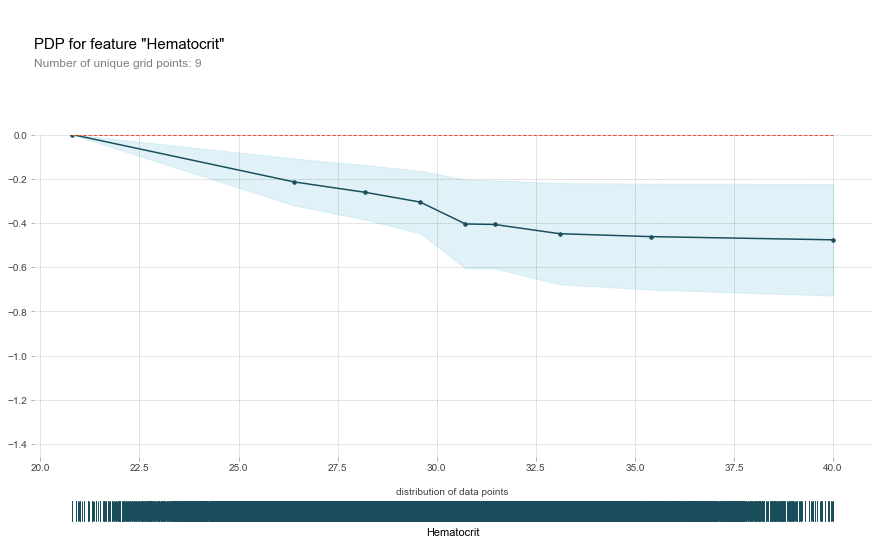

In [92]:
from pdpbox import pdp

data = final_input.drop(columns=['new_time']).reset_index(drop=True)
features = data.columns[:-1]
label = data.columns[-1]

pdp_gc = pdp.pdp_isolate(
    model=XGBoost,
    dataset=data,
    model_features = features,
    feature = 'Hematocrit')

fig, axes = pdp.pdp_plot(
    pdp_gc,
    'Hematocrit',
    plot_lines=False,
    frac_to_plot=0.5,
    plot_pts_dist=True
)

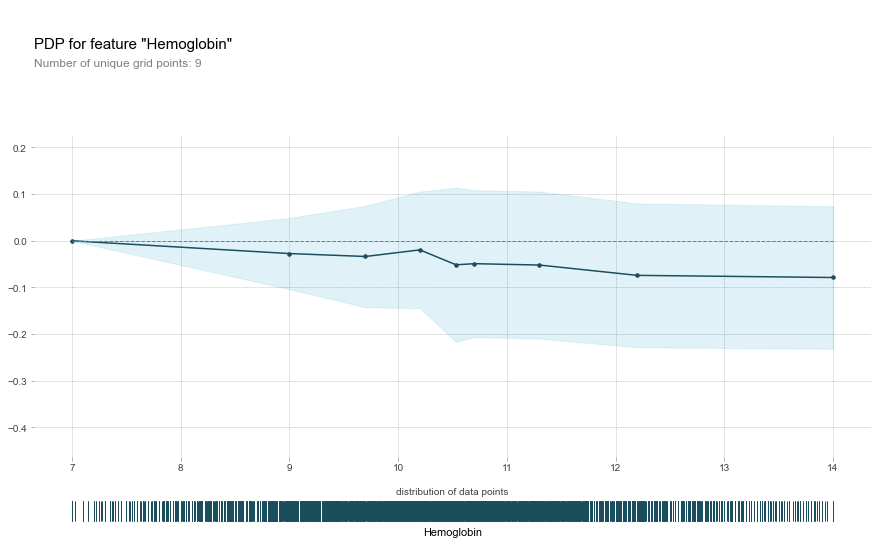

In [93]:
from pdpbox import pdp

data = final_input.drop(columns=['new_time']).reset_index(drop=True)
features = data.columns[:-1]
label = data.columns[-1]

pdp_gc = pdp.pdp_isolate(
    model=rf_clf,
    dataset=data,
    model_features = features,
    feature = 'Hemoglobin')

fig, axes = pdp.pdp_plot(
    pdp_gc,
    'Hemoglobin',
    plot_lines=False,
    frac_to_plot=0.5,
    plot_pts_dist=True
)

In [69]:
data.columns.shape

(44,)

In [71]:
data.columns.unique().shape

(43,)

In [20]:
data.columns

Index(['Base Excess', 'Calculated Total CO2', 'Free Calcium', 'Glucose',
       'Oxygen Saturation', 'pCO2', 'pH', 'pO2', 'Potassium, Whole Blood',
       'Hematocrit', 'Hemoglobin', 'Platelet Count', 'HR', ' Non Invasive SBP',
       ' Non Invasive DBP', 'RR', 'SpO2', 'Temp', 'CAL_AGE', 'GENDER',
       'label'],
      dtype='object')

In [ ]:
 '('CAL_TIME_AVG', 50868)', '('CAL_TIME_AVG', 50882)',
       '('CAL_TIME_AVG', 50902)', '('CAL_TIME_AVG', 50912)',
       '('CAL_TIME_AVG', 50931)', '('CAL_TIME_AVG', 50971)',
       '('CAL_TIME_AVG', 50983)', '('CAL_TIME_AVG', 51006)',
       '('CAL_TIME_AVG', 51221)', '('CAL_TIME_AVG', 51265)',
       '('CAL_TIME_AVG', 220045)', '('CAL_TIME_AVG', 220050)',
       '('CAL_TIME_AVG', 220051)', '('CAL_TIME_AVG', 220179)',
       '('CAL_TIME_AVG', 220180)', '('CAL_TIME_AVG', 220210)',
       '('CAL_TIME_AVG', 220277)', '('CAL_TIME_AVG', 223761)',
    
50868	Anion Gap
50882	Bicarbonate
50902	Chloride
50912	Creatinine
50931	Glucose
50971	Potassium
50983	Sodium
51006	Urea Nitrogen
51221	Hematocrit
51222	Hemoglobin
51265	Platelet Count
